In [8]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# fruits_veggies

## Data Preprocessing

In [9]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'fruits_veggies')

In [10]:
df['meal_ingredients'].isnull().sum()

0

In [11]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [18]:
df = df.dropna(axis=0, subset=['expert_assessment'])

In [19]:
df['meal_ingredients'].isnull().sum()

0

In [20]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [23]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [24]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 1795
Total negative labels: 1040
Total positive labels: 755


# TFIDF


## Meal Ingredients

In [25]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [26]:
df['meal_ingredients']

0                                             Boiling egg
1                                               Bagel egg
2                                     Turkey burger salad
3                                        Quinoa vegetable
4                                           Chicken salad
                              ...                        
1792    Omelette onion green pepper mushroom red peppe...
1793    Hero size French bread, butter lightly smeared...
1794    Regular bowl Minestrone soup, peas, carrots, b...
1795       8 oz chicken salad 1 large red delicious apple
1796    Parfait vanilla yogurt granola honey banana st...
Name: meal_ingredients, Length: 1795, dtype: object

In [27]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [28]:
document

['Boiling egg',
 'Bagel egg',
 'Turkey burger salad',
 'Quinoa vegetable',
 'Chicken salad',
 'Salad sweet potato',
 'Green bean strawberry',
 'Water grapefruit',
 'Coffee,turkey,bread',
 'Cream cheese',
 'Cream cheese ,substitute sugar,splenda',
 'Grapefruit cup',
 'Splenda coffee',
 'Bread',
 'Diet soda',
 'Coffee',
 'Avocado,tomatoes, onions,garlic',
 'Chick pea , tomatoes, lettuce, avocado',
 'Salad,chicken,avocado lemonade',
 'Milk fat free banana',
 'Grapefruit ,water',
 'Viandas ,chicken ,ginger ale,',
 'Eggs toast bacon tea grit',
 'Eggs ham',
 'Eggs ,sausage ,toast, tea',
 'Yellow rice vegetable, Honey glazed carrots, steam steak onion',
 'Yellow rice Gandules BBQ ribs. 16 oz glass V8.',
 'Chicken Alfredo bottle water.',
 '2 x ham/Swiss rapps, small potato salad 16 oz bottle water.',
 'Yellow rice corned beef, banana cup black coffee 2 tspn raw sugar.',
 'Egg cheese roll, banana cup black coffee 2 tspn sugar.',
 'White rice, red bean steak onions. 16 oz bottle water.',
 "Gener

In [29]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [31]:
print(X_train.shape, X_test.shape)

(1436,) (359,)


In [33]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


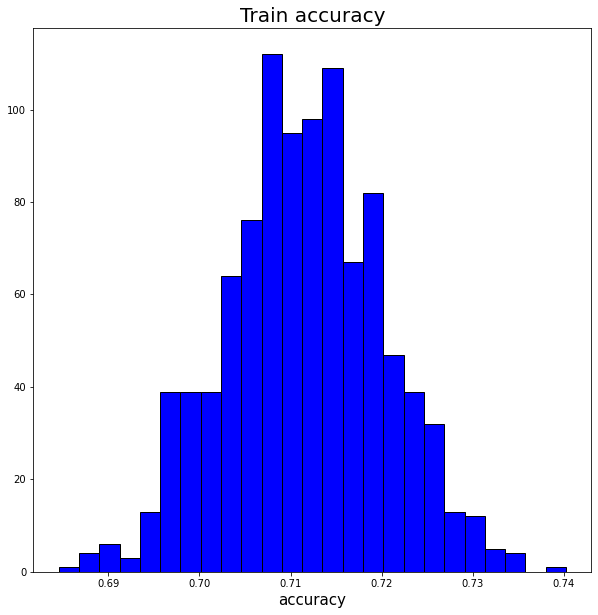

In [34]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [35]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7114456824512536
0.008619231987966392


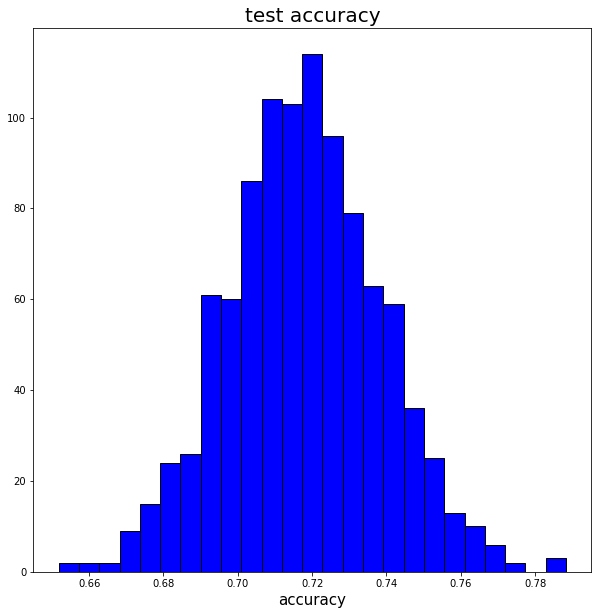

In [36]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [37]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7177520891364902
0.02100139474348736


# TFIDF Meal Title

In [51]:
df['meal_title'].isnull().sum()

0

In [52]:
df['meal_title'] = df['meal_title'].astype(str)

In [53]:
df = df.dropna(axis=0, subset=['meal_title'])

In [54]:
df['meal_title'].isnull().sum()

0

In [55]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [56]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [58]:
print(X_train.shape, X_test.shape)

(1436,) (359,)


In [59]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

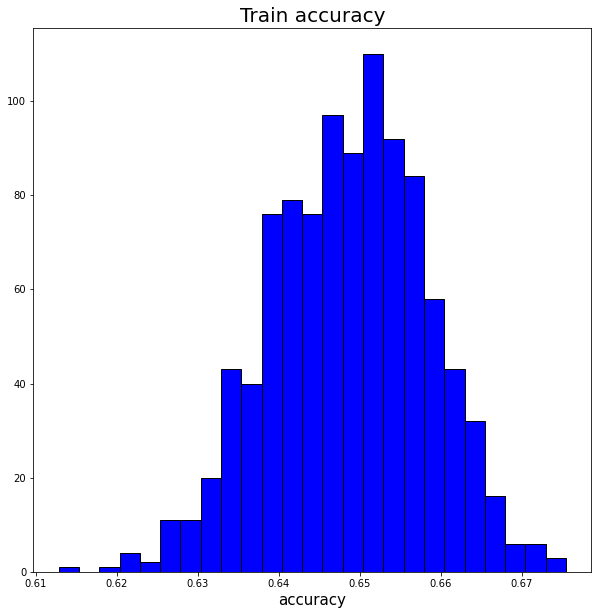

In [60]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [61]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6484965181058496
0.009635953659714341


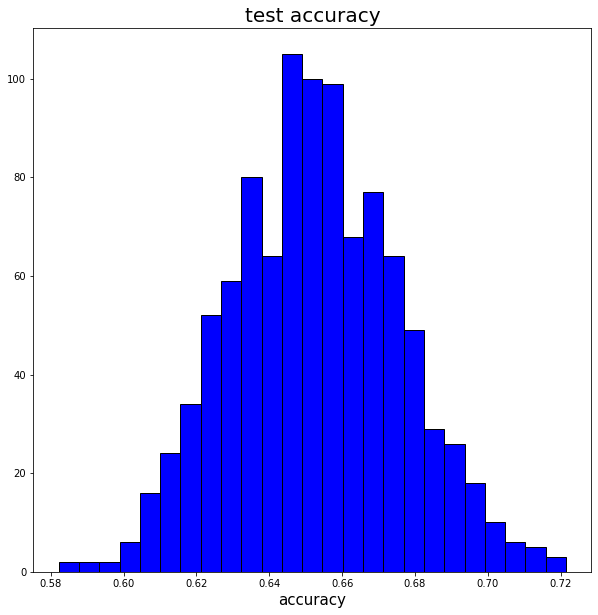

In [62]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [63]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6510835654596101
0.023112204518799716


# TFIDF Ingredients + Title

In [64]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [65]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [66]:
document

['Boiling egg Boiling eggs with one cracker',
 'Bagel egg 1/2bagel with one egg',
 'Turkey burger salad Salad with turkey burger',
 'Quinoa vegetable Quinoa and vegetables',
 'Chicken salad Chicken with mixed vegetables',
 'Salad sweet potato Salad ,sweet potatoes and avocado',
 'Green bean strawberry Alfredo fettuccine with oven chicken ,salad',
 'Water grapefruit Grapefruit',
 'Coffee,turkey,bread Sandwich',
 'Cream cheese Coffee and bread',
 'Cream cheese ,substitute sugar,splenda Bread with coffee',
 'Grapefruit cup Grapefruit',
 'Splenda coffee Italian bread with cream cheese and black coffee',
 'Bread Bread with cream cheese and black coffee',
 'Diet soda Diet Canada dry Ginger ale',
 'Coffee Bread with cream cheese',
 'Avocado,tomatoes, onions,garlic Boil vegetables,like yam,sweet potatoes etc.',
 'Chick pea , tomatoes, lettuce, avocado Spam,less sodium 25 percent',
 'Salad,chicken,avocado lemonade Rice,with beans ,avocado,chicken, and salad',
 'Milk fat free banana Honey bunche

In [67]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [69]:
print(X_train.shape, X_test.shape)

(1436,) (359,)


In [70]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


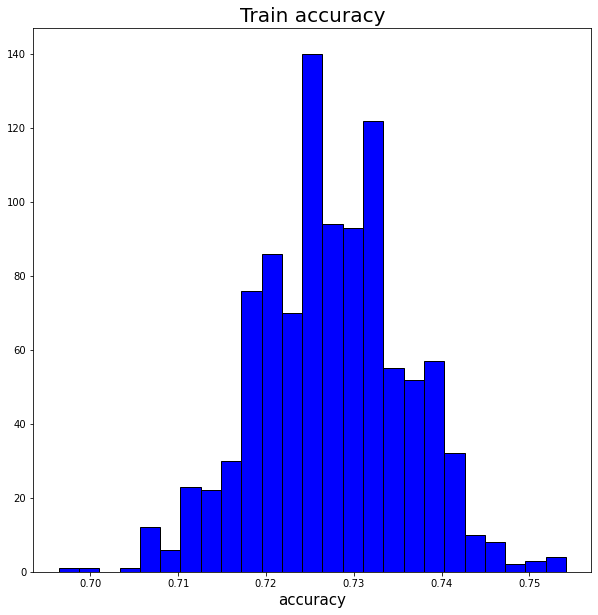

In [71]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [72]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7274547353760444
0.008431890347657827


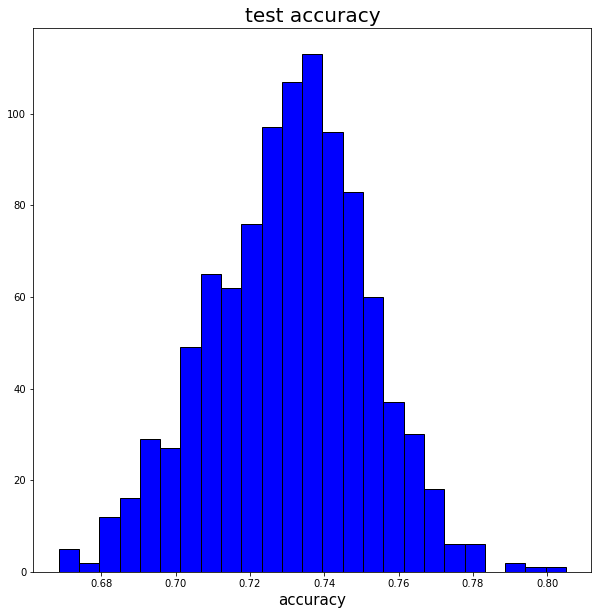

In [73]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [74]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7301838440111421
0.021485245753867663


# Word2vec

## ingredients

In [75]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [76]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [77]:
meal_ingredients

0                                          [boiling, egg]
1                                            [bagel, egg]
2                                 [turkey, burger, salad]
3                                     [quinoa, vegetable]
4                                        [chicken, salad]
                              ...                        
1792    [omelette, onion, green, pepper, mushroom, red...
1793    [hero, size, french, bread, butter, lightly, s...
1794    [regular, bowl, minestrone, soup, peas, carrot...
1795    [oz, chicken, salad, large, red, delicious, ap...
1796    [parfait, vanilla, yogurt, granola, honey, ban...
Name: meal_ingredients, Length: 1795, dtype: object

In [78]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [79]:
learned_words_meal_ingredients

['water',
 'oz',
 'chicken',
 'cup',
 'cheese',
 'egg',
 'tomato',
 'onion',
 'rice',
 'coffee',
 'bottle',
 'bread',
 'glass',
 'spinach',
 'salad',
 'milk',
 'lettuce',
 'orange',
 'green',
 'banana',
 'pepper',
 'wheat',
 'black',
 'red',
 'sugar',
 'whole',
 'bean',
 'white',
 'avocado',
 'slice',
 'beef',
 'half',
 'sauce',
 'mixed',
 'cucumber',
 'potato',
 'sandwich',
 'two',
 'organic',
 'one',
 'pork',
 'olive',
 'strawberry',
 'fish',
 'eggs',
 'oil',
 'apple',
 'broccoli',
 'corn',
 'salt',
 'soup',
 'yellow',
 'boiled',
 'butter',
 'yogurt',
 'beans',
 'ham',
 'fried',
 'tspn',
 'hard',
 'sausage',
 'breast',
 'onions',
 'fry',
 'turkey',
 'bacon',
 'garlic',
 'oatmeal',
 'tuna',
 'carrots',
 'steak',
 'hero',
 'tablespoon',
 'roll',
 'pickle',
 'cinnamon',
 'raw',
 'cracker',
 'celery',
 'hot',
 'small',
 'mustard',
 'piece',
 'shrimp',
 'blueberry',
 'vegetable',
 'quarter',
 'roast',
 'sweet',
 'seed',
 'peppers',
 'tomatoes',
 'juice',
 'seasoning',
 'dressing',
 'teasp

In [80]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [81]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [82]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [83]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [84]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

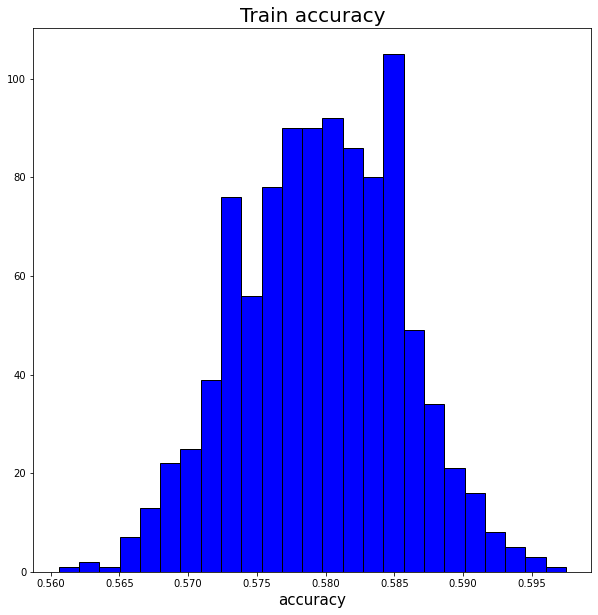

In [85]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [86]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5796183844011141
0.005847334095141537


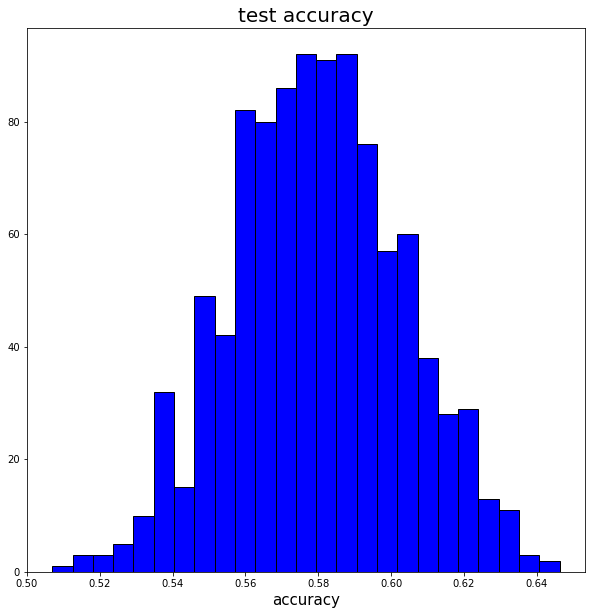

In [87]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [88]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.5783509749303621
0.023252232582995764


## title

In [89]:
df['meal_title'].isnull().sum()

0

In [90]:
df['meal_title'] = df['meal_title'].astype(str)

In [91]:
df = df.dropna(axis=0, subset=['meal_title'])

In [92]:
df['meal_title'].isnull().sum()

0

In [93]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [94]:
meal_title

0                     [boiling, eggs, with, one, cracker]
1                                 [bagel, with, one, egg]
2                           [salad, with, turkey, burger]
3                               [quinoa, and, vegetables]
4                      [chicken, with, mixed, vegetables]
                              ...                        
1792                [omelette, strawberries, and, coffee]
1793    [french, bread, hard, boiled, eggs, and, banan...
1794    [minestrone, soup, bakery, bread, and, bottle,...
1795                         [chicken, salad, and, apple]
1796                                             [yogurt]
Name: meal_title, Length: 1795, dtype: object

In [95]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [96]:
learned_words_meal_title

['and',
 'of',
 'water',
 'chicken',
 'salad',
 'with',
 'bottle',
 'rice',
 'coffee',
 'cheese',
 'sandwich',
 'eggs',
 'bread',
 'banana',
 'beans',
 'egg',
 'cup',
 'fish',
 'soup',
 'yogurt',
 'black',
 'mixed',
 'boiled',
 'milk',
 'fruit',
 'yellow',
 'hard',
 'oz',
 'oatmeal',
 'sausage',
 'dinner',
 'breakfast',
 'beef',
 'tuna',
 'orange',
 'lunch',
 'onions',
 'fried',
 'ham',
 'red',
 'pork',
 'steak',
 'on',
 'tomato',
 'cereal',
 'con',
 'potato',
 'lettuce',
 'crackers',
 'fries',
 'broccoli',
 'spinach',
 'shrimp',
 'juice',
 'wheat',
 'turkey',
 'roast',
 'glucerna',
 'potatoes',
 'vegetables',
 'carrots',
 'burger',
 'green',
 'french',
 'breast',
 'test',
 'apple',
 'half',
 'corn',
 'little',
 'sugar',
 'pizza',
 'whole',
 'toast',
 'bacon',
 'arroz',
 'cracker',
 'veggie',
 'raisin',
 'roll',
 'grits',
 'white',
 'peppers',
 'garden',
 'cabbage',
 'avocado',
 'salmon',
 'noodles',
 'tea',
 'chinese',
 'baked',
 'hot',
 'fry',
 'vegetable',
 'veggies',
 'tangerine',


In [97]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [98]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [99]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [100]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [101]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

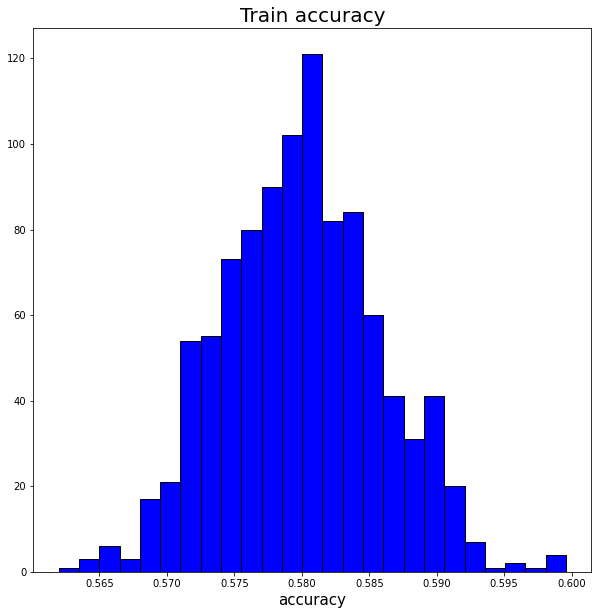

In [102]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [103]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5799777158774373
0.00585715851048902


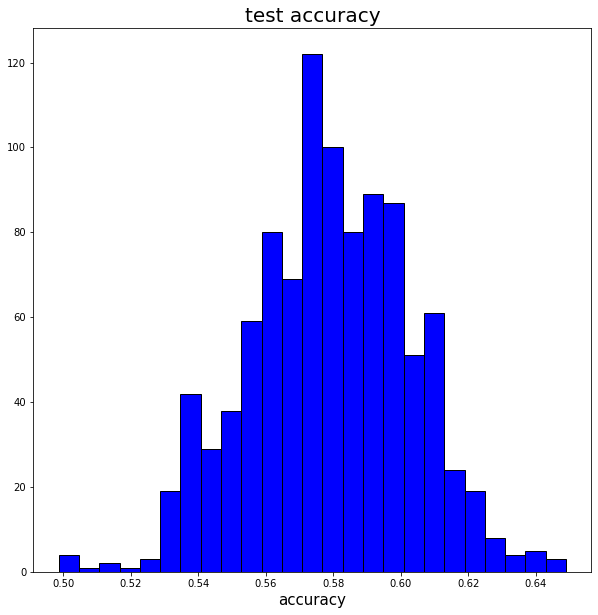

In [104]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [105]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.578732590529248
0.02392330796184305


## ingredients_and_title

In [106]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [107]:
df['ingredients_and_title']

0               Boiling egg Boiling eggs with one cracker
1                         Bagel egg 1/2bagel with one egg
2            Turkey burger salad Salad with turkey burger
3                  Quinoa vegetable Quinoa and vegetables
4             Chicken salad Chicken with mixed vegetables
                              ...                        
1792    Omelette onion green pepper mushroom red peppe...
1793    Hero size French bread, butter lightly smeared...
1794    Regular bowl Minestrone soup, peas, carrots, b...
1795    8 oz chicken salad 1 large red delicious apple...
1796    Parfait vanilla yogurt granola honey banana st...
Name: ingredients_and_title, Length: 1795, dtype: object

In [108]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [109]:
meal_ingredients_title

0       [boiling, egg, boiling, eggs, with, one, cracker]
1                     [bagel, egg, bagel, with, one, egg]
2       [turkey, burger, salad, salad, with, turkey, b...
3            [quinoa, vegetable, quinoa, and, vegetables]
4       [chicken, salad, chicken, with, mixed, vegetab...
                              ...                        
1792    [omelette, onion, green, pepper, mushroom, red...
1793    [hero, size, french, bread, butter, lightly, s...
1794    [regular, bowl, minestrone, soup, peas, carrot...
1795    [oz, chicken, salad, large, red, delicious, ap...
1796    [parfait, vanilla, yogurt, granola, honey, ban...
Name: ingredients_and_title, Length: 1795, dtype: object

In [110]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [111]:
learned_words_meal_ingredients_title

['and',
 'water',
 'chicken',
 'oz',
 'cheese',
 'bottle',
 'rice',
 'salad',
 'coffee',
 'cup',
 'egg',
 'of',
 'bread',
 'tomato',
 'banana',
 'onion',
 'with',
 'sandwich',
 'milk',
 'eggs',
 'orange',
 'glass',
 'spinach',
 'black',
 'lettuce',
 'green',
 'red',
 'wheat',
 'pepper',
 'beans',
 'mixed',
 'fish',
 'sugar',
 'soup',
 'beef',
 'yogurt',
 'whole',
 'boiled',
 'yellow',
 'white',
 'avocado',
 'potato',
 'half',
 'pork',
 'hard',
 'bean',
 'sausage',
 'sauce',
 'broccoli',
 'slice',
 'ham',
 'oatmeal',
 'fried',
 'onions',
 'tuna',
 'apple',
 'cucumber',
 'corn',
 'steak',
 'two',
 'turkey',
 'breast',
 'butter',
 'strawberry',
 'carrots',
 'one',
 'organic',
 'olive',
 'bacon',
 'fruit',
 'shrimp',
 'fry',
 'oil',
 'salt',
 'roast',
 'roll',
 'cracker',
 'juice',
 'garlic',
 'cereal',
 'hot',
 'french',
 'tspn',
 'hero',
 'vegetable',
 'peppers',
 'cabbage',
 'mustard',
 'sweet',
 'con',
 'raw',
 'breakfast',
 'pickle',
 'glucerna',
 'tablespoon',
 'celery',
 'veggie',
 

In [112]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [113]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [114]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [115]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [116]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

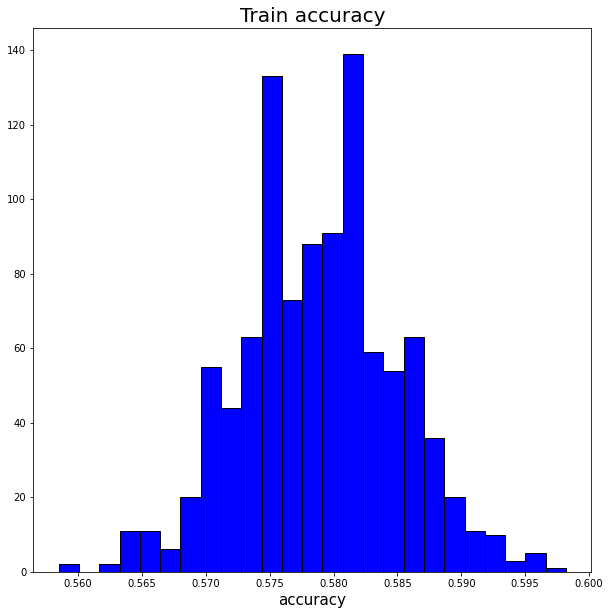

In [117]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [118]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.578875348189415
0.006078823795634404


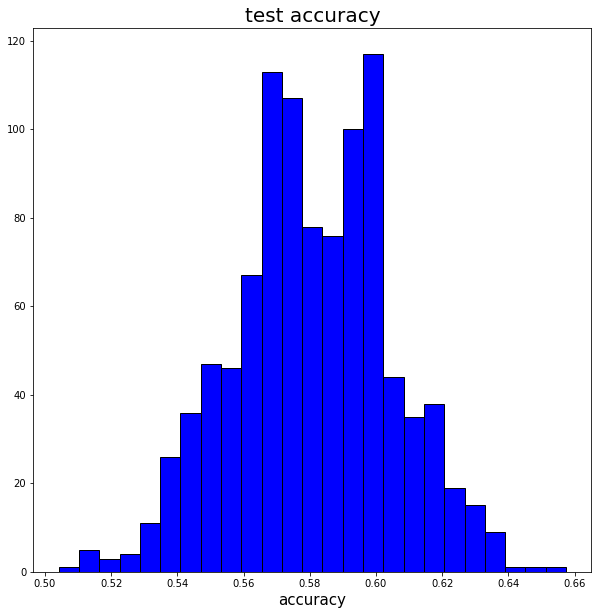

In [119]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [120]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.5805041782729804
0.02372765308206308


In [70]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'fruits_veggies')

In [71]:
df['meal_ingredients'].isnull().sum()

0

In [72]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [73]:
df = df.dropna(axis=0, subset=['expert_assessment'])

In [74]:
df['meal_ingredients'].isnull().sum()

0

In [75]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [76]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [77]:
meal_ingredients

0                                         [boiling, eggs]
1                                      [bagel, with, egg]
2                                 [turkey, burger, salad]
3                               [quinoa, and, vegetables]
4                                   [chicken, and, salad]
                              ...                        
1792    [omelette, with, onions, green, peppers, mushr...
1793    [hero, size, french, bread, butter, lightly, s...
1794    [regular, bowl, of, minestrone, soup, peas, ca...
1795    [oz, chicken, salad, large, red, delicious, ap...
1796    [parfait, vanilla, yogurt, granola, honey, ban...
Name: meal_ingredients, Length: 1795, dtype: object

In [78]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [79]:
learned_words_meal_ingredients

['and',
 'of',
 'water',
 'oz',
 'with',
 'chicken',
 'cheese',
 'cup',
 'rice',
 'coffee',
 'bottle',
 'bread',
 'glass',
 'eggs',
 'tomato',
 'spinach',
 'egg',
 'salad',
 'milk',
 'lettuce',
 'orange',
 'onions',
 'banana',
 'beans',
 'green',
 'wheat',
 'onion',
 'black',
 'red',
 'sugar',
 'whole',
 'avocado',
 'pepper',
 'beef',
 'tomatoes',
 'white',
 'peppers',
 'half',
 'sauce',
 'mixed',
 'two',
 'carrots',
 'organic',
 'sandwich',
 'pork',
 'one',
 'fish',
 'cucumber',
 'oil',
 'on',
 'broccoli',
 'yellow',
 'apple',
 'salt',
 'soup',
 'boiled',
 'corn',
 'potato',
 'butter',
 'yogurt',
 'ham',
 'fried',
 'hard',
 'tspn',
 'turkey',
 'garlic',
 'bacon',
 'oatmeal',
 'tuna',
 'breast',
 'steak',
 'hero',
 'sausage',
 'slice',
 'strawberries',
 'olives',
 'slices',
 'roll',
 'cinnamon',
 'raw',
 'celery',
 'fries',
 'hot',
 'strawberry',
 'mustard',
 'blueberries',
 'cups',
 'small',
 'shrimp',
 'peas',
 'in',
 'roast',
 'quarter',
 'tablespoon',
 'no',
 'sweet',
 'olive',
 's

In [80]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [81]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [82]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [83]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [84]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [86]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [87]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [88]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.5835654596100278
test accurcy: 0.5626740947075209


In [89]:
#Kfold

for i in range(2,10,1):
    k = i

    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression()

    train_acc_score = []
    test_acc_score = []

    for train_index , test_index in kf.split(data_X):
        X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
        y_train , y_test = data_y[train_index] , data_y[test_index]

        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy_score(y_test, y_pred_test)
        test_acc_score.append(test_acc)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_acc_score.append(train_acc)


    train_avg_acc_score = sum(train_acc_score)/k
    test_avg_acc_score = sum(test_acc_score)/k
    print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
    print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
    print()

train accuracy for k:2 is 0.5766009191737864
test accuracy for k:2 is 0.5805015729243481

train accuracy for k:3 is 0.6055665454978957
test accuracy for k:3 is 0.3843036424512798

train accuracy for k:4 is 0.5886559588144256
test accuracy for k:4 is 0.39269930202036274

train accuracy for k:5 is 0.5788300835654596
test accuracy for k:5 is 0.5727019498607242

train accuracy for k:6 is 0.5851833801322291
test accuracy for k:6 is 0.4300743218134522

train accuracy for k:7 is 0.5798491194996112
test accuracy for k:7 is 0.5748549541411896

train accuracy for k:8 is 0.5793861774114423
test accuracy for k:8 is 0.5793377976190476

train accuracy for k:9 is 0.5793863795678678
test accuracy for k:9 is 0.5793355667225014



### meal title

In [90]:
df['meal_title'].isnull().sum()

0

In [91]:
df['meal_title'] = df['meal_title'].astype(str)

In [92]:
df = df.dropna(axis=0, subset=['meal_title'])

In [93]:
df['meal_title'].isnull().sum()

0

In [94]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [95]:
meal_title

0                     [boiling, eggs, with, one, cracker]
1                                 [bagel, with, one, egg]
2                           [salad, with, turkey, burger]
3                               [quinoa, and, vegetables]
4                      [chicken, with, mixed, vegetables]
                              ...                        
1792                [omelette, strawberries, and, coffee]
1793    [french, bread, hard, boiled, eggs, and, banan...
1794    [minestrone, soup, bakery, bread, and, bottle,...
1795                         [chicken, salad, and, apple]
1796                                             [yogurt]
Name: meal_title, Length: 1795, dtype: object

In [96]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [97]:
learned_words_meal_title

['and',
 'of',
 'water',
 'chicken',
 'salad',
 'with',
 'bottle',
 'rice',
 'coffee',
 'cheese',
 'sandwich',
 'eggs',
 'bread',
 'banana',
 'beans',
 'egg',
 'cup',
 'fish',
 'soup',
 'yogurt',
 'black',
 'mixed',
 'boiled',
 'milk',
 'fruit',
 'yellow',
 'hard',
 'oz',
 'oatmeal',
 'sausage',
 'dinner',
 'breakfast',
 'beef',
 'tuna',
 'orange',
 'lunch',
 'onions',
 'fried',
 'ham',
 'red',
 'pork',
 'steak',
 'on',
 'tomato',
 'cereal',
 'con',
 'potato',
 'lettuce',
 'crackers',
 'fries',
 'broccoli',
 'spinach',
 'shrimp',
 'juice',
 'wheat',
 'turkey',
 'roast',
 'glucerna',
 'potatoes',
 'vegetables',
 'carrots',
 'burger',
 'green',
 'french',
 'breast',
 'test',
 'apple',
 'half',
 'corn',
 'little',
 'sugar',
 'pizza',
 'whole',
 'toast',
 'bacon',
 'arroz',
 'cracker',
 'veggie',
 'raisin',
 'roll',
 'grits',
 'white',
 'peppers',
 'garden',
 'cabbage',
 'avocado',
 'salmon',
 'noodles',
 'tea',
 'chinese',
 'baked',
 'hot',
 'fry',
 'vegetable',
 'veggies',
 'tangerine',


In [98]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [99]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [100]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [101]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [102]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [104]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [105]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [106]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.5877437325905293
test accurcy: 0.5459610027855153


In [107]:
#Kfold

for i in range(2,10,1):
    k = i

    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression()

    train_acc_score = []
    test_acc_score = []

    for train_index , test_index in kf.split(data_X):
        X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
        y_train , y_test = data_y[train_index] , data_y[test_index]

        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy_score(y_test, y_pred_test)
        test_acc_score.append(test_acc)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_acc_score.append(train_acc)


    train_avg_acc_score = sum(train_acc_score)/k
    test_avg_acc_score = sum(test_acc_score)/k
    print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
    print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
    print()

train accuracy for k:2 is 0.5832898823844888
test accuracy for k:2 is 0.5799447800512969

train accuracy for k:3 is 0.6025033319083662
test accuracy for k:3 is 0.3742701976352263

train accuracy for k:4 is 0.5964568503448862
test accuracy for k:4 is 0.36708682986000635

train accuracy for k:5 is 0.5864902506963788
test accuracy for k:5 is 0.5119777158774373

train accuracy for k:6 is 0.5930933623069172
test accuracy for k:6 is 0.46519137866963955

train accuracy for k:7 is 0.5867207994942808
test accuracy for k:7 is 0.5025165890772652

train accuracy for k:8 is 0.5849576520290132
test accuracy for k:8 is 0.542671130952381

train accuracy for k:9 is 0.5865596156884723
test accuracy for k:9 is 0.5704383026242322



### ingredients_and_title

In [108]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [109]:
df['ingredients_and_title']

0              Boiling eggs Boiling eggs with one cracker
1                    Bagel with egg 1/2bagel with one egg
2            Turkey burger salad Salad with turkey burger
3             Quinoa and vegetables Quinoa and vegetables
4         Chicken and salad Chicken with mixed vegetables
                              ...                        
1792    Omelette with onions green peppers mushrooms r...
1793    Hero size French bread, butter lightly smeared...
1794    Regular bowl of Minestrone soup, peas, carrots...
1795    8 oz chicken salad\n1 large red delicious appl...
1796    Parfait vanilla yogurt granola honey banana st...
Name: ingredients_and_title, Length: 1795, dtype: object

In [110]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [111]:
meal_ingredients_title

0       [boiling, eggs, boiling, eggs, with, one, crac...
1               [bagel, with, egg, bagel, with, one, egg]
2       [turkey, burger, salad, salad, with, turkey, b...
3       [quinoa, and, vegetables, quinoa, and, vegetab...
4       [chicken, and, salad, chicken, with, mixed, ve...
                              ...                        
1792    [omelette, with, onions, green, peppers, mushr...
1793    [hero, size, french, bread, butter, lightly, s...
1794    [regular, bowl, of, minestrone, soup, peas, ca...
1795    [oz, chicken, salad, large, red, delicious, ap...
1796    [parfait, vanilla, yogurt, granola, honey, ban...
Name: ingredients_and_title, Length: 1795, dtype: object

In [112]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [113]:
learned_words_meal_ingredients_title

['and',
 'of',
 'water',
 'with',
 'chicken',
 'oz',
 'cheese',
 'bottle',
 'rice',
 'salad',
 'coffee',
 'cup',
 'bread',
 'eggs',
 'egg',
 'banana',
 'beans',
 'sandwich',
 'milk',
 'tomato',
 'orange',
 'glass',
 'onions',
 'spinach',
 'black',
 'lettuce',
 'green',
 'red',
 'wheat',
 'mixed',
 'fish',
 'soup',
 'beef',
 'onion',
 'sugar',
 'yogurt',
 'whole',
 'boiled',
 'yellow',
 'avocado',
 'white',
 'pork',
 'half',
 'peppers',
 'on',
 'hard',
 'pepper',
 'carrots',
 'tomatoes',
 'broccoli',
 'ham',
 'sauce',
 'fried',
 'oatmeal',
 'potato',
 'sausage',
 'tuna',
 'apple',
 'corn',
 'steak',
 'two',
 'turkey',
 'cucumber',
 'butter',
 'one',
 'breast',
 'organic',
 'fries',
 'bacon',
 'shrimp',
 'oil',
 'fruit',
 'salt',
 'roll',
 'crackers',
 'roast',
 'garlic',
 'juice',
 'strawberries',
 'cereal',
 'slices',
 'french',
 'hot',
 'tspn',
 'hero',
 'vegetables',
 'slice',
 'peas',
 'potatoes',
 'in',
 'no',
 'mustard',
 'cabbage',
 'sweet',
 'con',
 'olives',
 'breakfast',
 'raw

In [114]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [115]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [116]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
data_y = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [117]:
data_y = np.squeeze(data_y)
data_y.shape

(1795,)

In [118]:
data_X = pd.DataFrame(l)
data_X.shape

(1795, 100)

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

In [121]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [122]:
from sklearn.metrics import accuracy_score
print('train accurcy:',accuracy_score(y_train, y_pred_train))
print('test accurcy:',accuracy_score(y_test, y_pred_test))

train accurcy: 0.5926183844011143
test accurcy: 0.5264623955431755


In [123]:
#Kfold

for i in range(2,10,1):
    k = i

    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression()

    train_acc_score = []
    test_acc_score = []

    for train_index , test_index in kf.split(data_X):
        X_train , X_test = data_X.iloc[train_index,:],data_X.iloc[test_index,:]
        y_train , y_test = data_y[train_index] , data_y[test_index]

        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy_score(y_test, y_pred_test)
        test_acc_score.append(test_acc)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_acc_score.append(train_acc)


    train_avg_acc_score = sum(train_acc_score)/k
    test_avg_acc_score = sum(test_acc_score)/k
    print('train accuracy for k:' + str(k) + ' is ' +  str(train_avg_acc_score))
    print('test accuracy for k:' + str(k) + ' is ' +  str(test_avg_acc_score))
    print()

train accuracy for k:2 is 0.5732607826633197
test accuracy for k:2 is 0.5732564375684353

train accuracy for k:3 is 0.6025033319083662
test accuracy for k:3 is 0.3742701976352263

train accuracy for k:4 is 0.5892131653523156
test accuracy for k:4 is 0.39492647351256766

train accuracy for k:5 is 0.5795264623955432
test accuracy for k:5 is 0.5777158774373259

train accuracy for k:6 is 0.596658424695509
test accuracy for k:6 is 0.4434522482348569

train accuracy for k:7 is 0.57947788123683
test accuracy for k:7 is 0.5793105544747083

train accuracy for k:8 is 0.5793861774114423
test accuracy for k:8 is 0.5793377976190476

train accuracy for k:9 is 0.5793863795678678
test accuracy for k:9 is 0.5793355667225014

